# <font style="color:blue">Table of Content</font>

- [Step 1: Understand Your Problem](#step1)
- [Step 2: Get the Data](#step2)
- [Step 3. Data Preparation](#step3)
- [Step 4: Train a Simple Model](#step4)
- [Step 5: Sample Prediction](#step5)
- [Step 6. Display Mistakes](#step6)

# <font style="color:blue">Project 1 - Part 2: Train an Image Classifier From Scratch</font>
As discussed in the previous notebook, the steps for training Neural Networks are:

- Step 1 - Understand your problem
- Step 2A - Get the data
- Step 2B - Explore and understand your data
- Step 2C - Create a sample data from the dataset
- Step 3 - Data preparation
- Step 4 - Train a simple model on sample data and check the pipeline before proceeding to train the full network
- Step 5 - Train on full data
- Step 6 - Improve your model

You have already been through Steps `1-4` in the previous notebook. Use them here as well.

Here, you will implement Steps `5` & `6` from scratch. Design a model that achieves `>=85%` validation accuracy on the given dataset.

There are 70 points for this notebook. The sections which carry marks are in Red.

There are **70 points** for this notebook. <font style="color:red">The sections which carry marks are in Red.</font>

For GPU compute you can use Kaggle Kernels, Google Colab or any other service of your choice.

After completing the assignment, upload and submit it on the portal for feedback.

<font style="color:red">Use the full data to train the network. You need to achieve 85% accuracy for validation data to successfully complete this assignment.</font>


<font style="color:red">Just remember to build your own model, not use any pre-trained models/weights.</font>


Upon completing the assignment, <font style="color:red">upload the notebook and the models folder on the portal for  feedback.</font>

# <font style="color:blue">Step 1: Understand Your problem </font><a name="step1"></a>
Already covered in the previous notebook.

# <font style="color:blue">Step 2: Get the Data </font><a name="step2"></a>

Already covered in the previous notebook.

In [1]:
# !wget "https://www.dropbox.com/sh/n5nya3g3airlub6/AACi7vaUjdTA0t2j_iKWgp4Ra?dl=1" -O data.zip

### <font style="color:green">Extract the Data</font>

In [2]:
# !unzip -q data.zip

# <font style="color:blue">Step 3. Data Preparation</font><a name="step3"></a>
Already covered in the previous notebook.

## <font style="color:blue">3.1. Import Libraries </font>

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [5]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

from torch.optim import lr_scheduler

### <font style="color:green">3.2.1. Compulsary Preprocessing Transforms</font>

In [6]:
def image_preprocess_transforms():
    
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
        ])
    
    return preprocess

### <font style="color:green">3.2.2. Common Image Transforms</font>

In [7]:
def image_common_transforms(mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms()
    
    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])
    
    return common_transforms
    

### <font style="color:green">3.2.3. Mean and STD</font>

In [8]:
def get_mean_std(data_root, num_workers=4):
    
    transform = image_preprocess_transforms()
    
    loader = data_loader(data_root, transform)
    
    batch_mean = torch.zeros(3)
    batch_mean_sqrd = torch.zeros(3)
    
    for batch_data, _ in loader:
        batch_mean += batch_data.mean(dim=(0, 2, 3)) # E[batch_i] 
        batch_mean_sqrd += (batch_data ** 2).mean(dim=(0, 2, 3)) #  E[batch_i**2]
    
    # E[dataset] = E[E[batch_1], E[batch_2], ...]
    mean = batch_mean / len(loader)
    
    # var[X] = E[X**2] - E[X]**2
    
    # E[X**2] = E[E[batch_1**2], E[batch_2**2], ...]
    # E[X]**2 = E[E[batch_1], E[batch_2], ...] ** 2
    
    var = (batch_mean_sqrd / len(loader)) - (mean ** 2)
        
    std = var ** 0.5
    print('mean: {}, std: {}'.format(mean, std))
    
    return mean, std

## <font style="color:blue">3.3. Data Loaders </font>

### <font style="color:green">3.3.1. Data Loader for Full Data</font>
Data loader for generating batches of data to be used by the training routine

In [9]:
def data_loader(data_root, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    
    return loader

## <font style="color:green">3.4. Prepare Data</font>
The main function which uses all the above functions to generate the train and test dataloaders.


In [10]:
# Define the missing data_augmentaaion_preprocess function
def data_augmentation_preprocess(mean, std):
    return transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

def get_data(batch_size, data_root, num_workers=4, data_augmentation=True):
    
    train_data_path = os.path.join(data_root, 'training')
       
    mean, std = get_mean_std(data_root=train_data_path, num_workers=num_workers)
    
    common_transforms = image_common_transforms(mean, std)
        
   
    # if data_augmentation is true 
    # data augmentation implementation
    if data_augmentation:    
        train_transforms = data_augmentation_preprocess(mean, std)
    # else do common transforms
    else:
        train_transforms = common_transforms
        
        
    # train dataloader
    
    train_loader = data_loader(train_data_path, 
                               train_transforms, 
                               batch_size=batch_size, 
                               shuffle=True, 
                               num_workers=num_workers)
    
    # test dataloader
    
    test_data_path = os.path.join(data_root, 'validation')
    
    test_loader = data_loader(test_data_path, 
                              common_transforms, # use common transforms for validation
                              batch_size=batch_size, 
                              shuffle=False, 
                              num_workers=num_workers)
    
    return train_loader, test_loader

# <font style="color:blue">Step 4: Train Your Model</font><a name="step4"></a>

Now, create the training pipeline, and train your model on the full data.

## <font style="color:red">4.1. Configurations [20 Points]</font>

To achieve good results, change the parameters given in these configurations. Score 20 points for all right choices.

### <font style="color:green">4.1.1. System Configuration</font>

Fix the seed (e.g., `21`) to get a reproducible result. 

In [11]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 2025  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

### <font style="color:green">4.1.2. Training Configuration</font>

In [12]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32 # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 200  # number of times the whole dataset will be passed through the network
    init_learning_rate: float = 0.01  # initial learning rate for lr scheduler
    # weight_decay: float = 0.0001 # parameter for optimizer to perform L2 regularization
    log_interval: int = 5 # how many batches to wait before logging training status  
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to test every epoch
    data_root: str = "./cat-dog-panda/"  # root directory of the dataset
    num_workers: int = 4  # number of concurrent processes using to prepare data
    device: str = 'cuda'  # device to use for training.
    lr_scheduler_patience: int = 5     # Patience (in epochs) for ReduceLROnPlateau scheduler
    lr_scheduler_factor: float = 0.25   # LR reduction factor when plateauing
    early_stopping_patience: int = 10  # Patience (in epochs) for early stopping
    


### <font style="color:green">4.1.3. System Setup</font>

In [13]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:blue">4.2. Training Function</font>

You are already familiar with the training function. No changes needed here.

In [14]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

## <font style="color:blue">4.3. Validation Function</font>

In [15]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        with torch.no_grad():
            output = model(data)
        
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    
    return test_loss, accuracy/100.0

## <font style="color:blue">4.4. Save the Model</font>

In [16]:
def save_model(model, device, model_dir='models', model_file_name='cat_dog_panda_classifier.pt'):
    

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)
    
    if device == 'cuda':
        model.to('cuda')
    
    return

## <font style="color:blue">4.5. Load the Model</font>

In [17]:
def load_model(model, model_dir='models', model_file_name='cat_dog_panda_classifier.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))
    
    return model

## <font style="color:blue">4.6. Main Function for Training</font>

Note: Before calling the train function, we calculate the validation loss, which we know should be close to $\log(\text{num_classes})$. Also, the accuracy should be close to $\frac{1}{\text{num_classes}}$.

In [18]:
def main(model, optimizer, scheduler=None, early_stopping=None, 
         system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration(), 
         data_augmentation=True):
    
    # system configuration
    setup_system(system_configuration)

    # batch size, num_workers and epoch count
    batch_size_to_set = training_configuration.batch_size
    num_workers_to_set = training_configuration.num_workers
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, else lower some parameters.
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )
    
    # Update training configuration with system-adjusted parameters
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # Send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = float('inf')
    
    # Arrays to track epoch train/test loss and accuracy
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # Calculate Initial Test Loss
    init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader)
    print("Initial Test Loss : {:.6f}, \nInitial Test Accuracy : {:.3f}%\n".format(
        init_val_loss, init_val_accuracy*100))
    
    # training time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        epoch_train_loss = np.append(epoch_train_loss, train_loss)
        epoch_train_acc = np.append(epoch_train_acc, train_acc)
        
        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        print("Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta))
        
        # Validate at set interval
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            epoch_test_loss = np.append(epoch_test_loss, current_loss)
            epoch_test_acc = np.append(epoch_test_acc, current_accuracy)
            
            # Early stopping check using validation loss
            if early_stopping is not None:
                early_stopping(current_loss, model)
                if early_stopping.early_stop:
                    print("Early stopping triggered")
                    break

            # Scheduler step/update; prefer validation loss for ReduceLROnPlateau
            if scheduler is not None:
                if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(current_loss)
                    print("Bad Epochs: {}".format(scheduler.num_bad_epochs))
                    print("last LR = {}".format(scheduler._last_lr))
                else:
                    scheduler.step()

            # Save the model if loss has improved
            if current_loss < best_loss:
                best_loss = current_loss
                print('Model Improved. Saving the Model...\n')
                save_model(model, device=training_configuration.device)
        
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

## <font style="color:blue">4.7. Plot Loss and Accuracy</font>

In [19]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors, 
                       loss_legend_loc='upper center', acc_legend_loc='upper left', 
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = train_loss[i].min()
        
        min_val_loss = val_loss[i].min()
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID LOSS ({0:.4})".format(min_val_loss))
        
    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = train_acc[i].max() 
        
        max_val_acc = val_acc[i].max() 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID ACC ({0:.4})".format(max_val_acc))
        
    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')
    
    fig.savefig('sample_loss_acc_plot.png')
    plt.show()
    
    return   

## <font style="color:red">4.8. Define Model [20 Points]</font>

Next, define the CNN model. Keep iterating. Do this by training various models. Just ,change the :
    
- number of layers
- parameters inside the layers
- different types of layers

In [20]:
class MyCNN(nn.Module):
    def __init__(self, num_classes=13):
        super(MyCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1: Input: 3x224x224 -> after conv: 32x224x224, then pool: 32x112x112
            nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Block 2: 32x112x112 -> 64x112x112, then pool: 64x56x56
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Block 3: 64x56x56 -> 128x56x56, then pool: 128x28x28
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        
        # Adaptive pooling to collapse spatial dimensions
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
          
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128, 512),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

### updating the network architecture

In [21]:
import torch.nn as nn

class MyCNN(nn.Module):
    def __init__(self, num_classes=13):
        super(MyCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1: Input: 3x224x224 -> after conv: 64x112x112, then pool: 64x56x56
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 2: 64x56x56 -> after conv: 128x56x56, then pool: 128x28x28
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 3: 128x28x28 -> after conv: 256x28x28, then pool: 256x14x14
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 4: 256x14x14 -> after conv: 512x14x14, then pool: 512x7x7
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        
        # Adaptive pooling to collapse spatial dimensions
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
          
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

## <font style="color:red">4.9. Training [20 Points]</font>

Experiment with:

- Optimizers and learning rate schedulers \[You can  get good results even without a learning rate scheduler\]

- Regularization techniques like Data Augmentation, Dropout, BatchNorm

In [22]:
# Define early stopping class
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, checkpoint_path='checkpoint.pt'):
        """
        Args:
            patience (int): Number of epochs with no improvement after which training will be stopped.
            verbose (bool): If True, prints messages when the validation loss decreases.
            delta (float): Minimum change in the validation loss to qualify as an improvement.
            checkpoint_path (str): Path to save the best model.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.checkpoint_path = checkpoint_path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss  # lower loss is better

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.checkpoint_path)
        self.val_loss_min = val_loss

In [23]:
model = MyCNN()
print(model)

train_config = TrainingConfiguration()

# optimizer (using Adam)
optimizer = optim.Adam(
    model.parameters(),
    lr=train_config.init_learning_rate
)

# Initialize early stopping
early_stopping = EarlyStopping(patience=train_config.early_stopping_patience, verbose=True)

# ReduceLROnPlateau scheduler to decay LR when validation stops improving
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                           mode= 'min', # reduce LR when validation loss stops improving
                                           factor=train_config.lr_scheduler_factor,
                                           patience=train_config.lr_scheduler_patience,
                                           verbose=True)

MyCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, aff

C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [24]:
# train and validate
model, train_loss, train_acc, val_loss, val_acc = main(model, optimizer, scheduler=scheduler,
                                                        early_stopping= None,
                                                       data_augmentation=True)

mean: tensor([0.4610, 0.4347, 0.3897]), std: tensor([0.2734, 0.2641, 0.2616])

Test set: Average loss: 2.5787, Accuracy: 0/600 (0%)

Initial Test Loss : 2.578707, 
Initial Test Accuracy : 0.000%

Epoch: 0 
Train Loss: 1.213193 Acc: 0.5012
Elapsed 18.88s, 18.88 s/epoch, 0.25 s/batch, ets 3756.49s

Test set: Average loss: 0.8421, Accuracy: 342/600 (57%)

Bad Epochs: 0
last LR = [0.01]
Model Improved. Saving the Model...

Epoch: 1 
Train Loss: 0.881289 Acc: 0.5367
Elapsed 42.27s, 21.14 s/epoch, 0.28 s/batch, ets 4184.97s

Test set: Average loss: 0.8491, Accuracy: 332/600 (55%)

Bad Epochs: 1
last LR = [0.01]
Epoch: 2 
Train Loss: 0.866300 Acc: 0.5433
Elapsed 65.83s, 21.94 s/epoch, 0.29 s/batch, ets 4322.96s

Test set: Average loss: 0.9067, Accuracy: 322/600 (54%)

Bad Epochs: 2
last LR = [0.01]
Epoch: 3 
Train Loss: 0.842882 Acc: 0.5725
Elapsed 89.40s, 22.35 s/epoch, 0.30 s/batch, ets 4380.44s

Test set: Average loss: 0.7459, Accuracy: 358/600 (60%)

Bad Epochs: 0
last LR = [0.01]
Model I

## <font style="color:blue">4.10. Loss and Accuracy Plot</font>

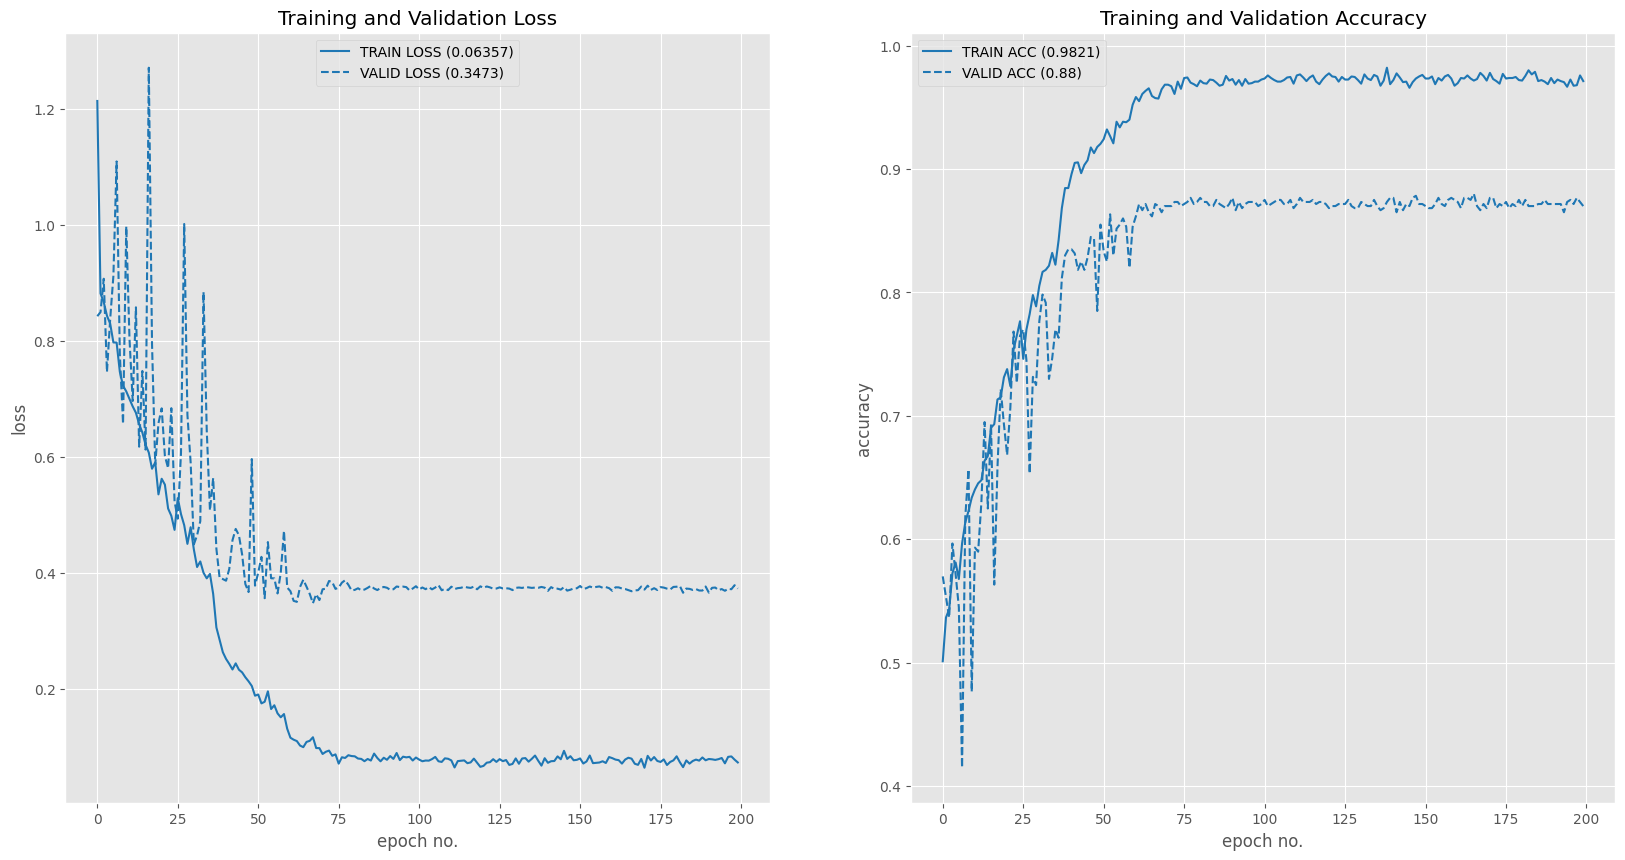

In [25]:
plot_loss_accuracy(train_loss=[train_loss], 
                   val_loss=[val_loss], 
                   train_acc=[train_acc], 
                   val_acc=[val_acc], 
                   colors=['blue'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

# <font style="color:blue">Step 5. Sample Prediction</font><a name="step5"></a>

Show some sample predictions.

## <font style="color:blue">5.1. Make Predictions</font>

In [26]:
def prediction(model, device, batch_input):
    
    data = batch_input.to(device)
    
    with torch.no_grad():
        output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

## <font style="color:blue">5.2. Get Predictions on a Batch</font>

In [27]:
def get_sample_prediction(model, data_root, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
    
    # It is important to do model.eval() before prediction
    model.eval()
    
    # Send model to cpu/cuda according to your system configuration
    model.to(device)

    # transformed data
    test_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(mean, std))
    
    # original image dataset
    test_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms())
    
    data_len = test_dataset.__len__()
    
    interval = int(data_len/batch_size)
    
    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = test_dataset_trans.__getitem__(index)
        img, _ = test_dataset.__getitem__(index)
        
        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)
        
    inputs = torch.stack(inputs)
        
    cls, prob = prediction(model, device, batch_input=inputs)
    
    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()
    
    
    for i, target in enumerate(targets):
        plt.subplot(3, 5, i+1)
        img = transforms.functional.to_pil_image(imgs[i])
        plt.imshow(img)
        plt.gca().set_title('P:{0}({1:.2}), T:{2}'.format(test_dataset.classes[cls[i]], 
                                                     prob[i], 
                                                     test_dataset.classes[targets[i]]))
    fig.savefig('sample_prediction.png')
    plt.show()
    
    return
        
    

## <font style="color:blue">5.3. Load Model and Run Inference</font>

mean: tensor([0.4610, 0.4347, 0.3897]), std: tensor([0.2734, 0.2641, 0.2616])


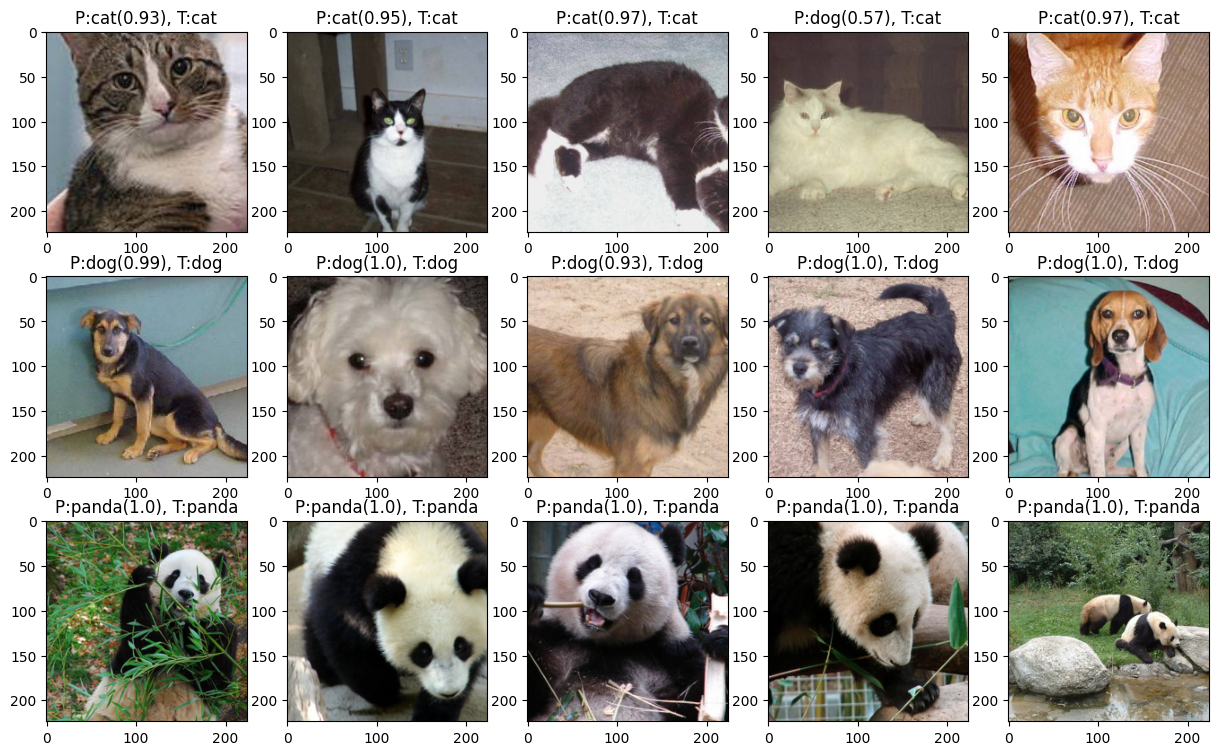

In [28]:
m = MyCNN()
m = load_model(m)

train_config = TrainingConfiguration()

test_data_path = os.path.join(train_config.data_root, 'validation')
train_data_path = os.path.join(train_config.data_root, 'training')

mean, std = get_mean_std(train_data_path)

get_sample_prediction(m, test_data_path, mean, std)

# <font style="color:red">Step 6. Display Confusion Matrix [10 Points]</font><a name="step6"></a>

Display the confusion matrix for the above problem(Refer to the earlier lectures on Performance Metrics).


The output should resemble this:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/02/c3_w5_sample_confusion_matrix.png' width=600>


In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, data_root, mean, std, batch_size=32):
    # Set device and move model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    
    # Create dataset and dataloader with common transforms
    test_dataset = datasets.ImageFolder(
        root=data_root,
        transform=image_common_transforms(mean, std)
    )
    dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    all_preds = []
    all_targets = []
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

./cat-dog-panda/validation
mean: tensor([0.4610, 0.4347, 0.3897]), std: tensor([0.2734, 0.2641, 0.2616])


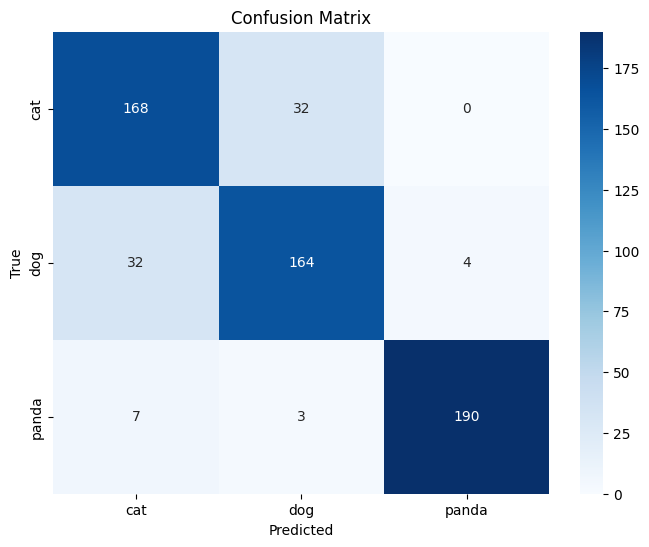

In [30]:
m = MyCNN()
m = load_model(m)

train_config = TrainingConfiguration()

test_data_path = os.path.join(train_config.data_root, 'validation')
train_data_path = os.path.join(train_config.data_root, 'training')
print(test_data_path)

mean, std = get_mean_std(train_data_path)
plot_confusion_matrix(model, data_root=test_data_path, mean= mean, std=std)

# <font style="color:Orange">Plotting Sample Mistakes </font><a name="display"></a>

To understand where the model went wrong, lets look at some of the misclassification.


**Displaying only 15 images.**

In [31]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

def get_sample_mistakes(model, data_root, mean, std, sample_count=15):
    # Device configuration
    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2

    model.eval()
    model.to(device)
    
    # Transformed dataset: used as model input
    test_dataset_trans = datasets.ImageFolder(root=data_root, 
                                               transform=image_common_transforms(mean, std))
    # Original dataset: used for visualization
    test_dataset = datasets.ImageFolder(root=data_root, 
                                         transform=image_preprocess_transforms())
    
    mistakes_imgs = []
    mistakes_targets = []
    mistakes_preds = []
    
    data_len = len(test_dataset)
    
    # Iterate over test dataset until we collect sample_count mistakes.
    for index in range(data_len):
        # Get transformed input and original image & target
        input_img, target = test_dataset_trans.__getitem__(index)
        original_img, _ = test_dataset.__getitem__(index)
        
        # Add batch dimension and send to device
        input_tensor = input_img.unsqueeze(0).to(device)
        
        # Get prediction using the provided prediction function.
        pred_class, prob = prediction(model, device, batch_input=input_tensor)
        
        # If the prediction is wrong, record this sample.
        if pred_class[0] != target:
            mistakes_imgs.append(original_img)
            mistakes_targets.append(target)
            mistakes_preds.append((pred_class[0], prob[0]))
        
        if len(mistakes_imgs) >= sample_count:
            break

    # Plot misclassified images
    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()
    
    for i, target in enumerate(mistakes_targets):
        plt.subplot(3, 5, i+1)
        img = transforms.functional.to_pil_image(mistakes_imgs[i])
        predicted_class, probability = mistakes_preds[i]
        title = 'P: {0} ({1:.2f}), T: {2}'.format(test_dataset.classes[predicted_class], 
                                                     probability, 
                                                     test_dataset.classes[target])
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")
    
    fig.savefig('sample_mistakes.png')
    plt.show()

mean: tensor([0.4610, 0.4347, 0.3897]), std: tensor([0.2734, 0.2641, 0.2616])


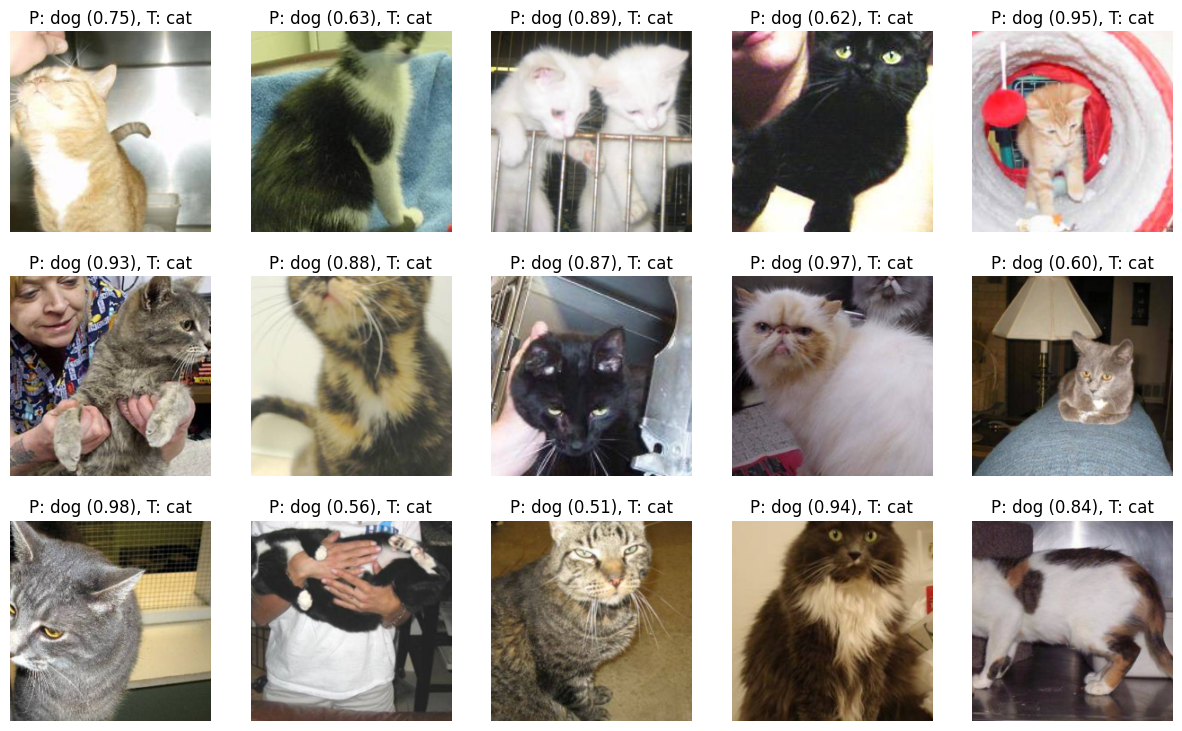

In [32]:
m = MyCNN()
m = load_model(m)

train_config = TrainingConfiguration()

test_data_path = os.path.join(train_config.data_root, 'validation')
train_data_path = os.path.join(train_config.data_root, 'training')

mean, std = get_mean_std(train_data_path)

get_sample_mistakes(m, test_data_path, mean, std)

## Reflection on Model Training and Performance

This notebook detailed the iterative process of refining our image classification model, culminating in significant improvements in performance.  Several key changes to the architecture and training configuration contributed to this progress.

**Enhanced Feature Extraction through Deeper Convolutional Layers:**

Initially, our model struggled to effectively differentiate between classes, as evidenced by the confusion in misclassifications. To address this, we strategically increased the number of convolutional layers in the network's body. This modification facilitated the learning of more complex and abstract features.  Deeper layers allow the model to progressively learn hierarchical representations, moving from simple edge detection in early layers to more nuanced, class-specific features in later layers. This enhancement proved crucial in enabling the model to discern subtle differences between categories, leading to improved accuracy.

**Refining Regularization with Reduced Dropout:**

Regularization plays a vital role in preventing overfitting. Initially, we employed a relatively high dropout rate to constrain the model's complexity. However, with the increased depth of the network, we found that this level of regularization became overly restrictive.  Reducing the dropout rate allowed the model to leverage its increased capacity while still maintaining reasonable generalization. This balance between complexity and regularization was essential for optimizing performance.

**The Impact of Learning Rate Scheduling with ReduceLROnPlateau:**

We adopted the ReduceLROnPlateau learning rate scheduler to dynamically adjust the learning rate during training. This scheduler monitors the validation loss and reduces the learning rate when a plateau is detected, allowing the model to fine-tune its parameters in later epochs. The factor parameter of this scheduler plays a crucial role.  If the factor is too high, the learning rate might be reduced too aggressively, preventing the model from escaping local minima or plateaus. Conversely, a more moderate factor allows for gradual refinement.  Through experimentation, we identified an optimal factor that enabled the model to converge effectively.

**The Importance of Epochs and Convergence:**

Increasing the number of training epochs is essential for allowing the model sufficient time to learn.  As our model converged, we observed that the validation loss continued to decrease, albeit at a slower rate.  This suggested that further training could yield additional improvements.  However, it's crucial to strike a balance to avoid overfitting.  Monitoring the validation loss and accuracy provides insights into when the model begins to overfit, signaling the need to stop training or adjust regularization.

**Early Stopping: A Double-Edged Sword:**

While early stopping can be a useful technique to prevent overfitting and save computational resources, we chose to disable it in this phase of experimentation.  Our primary goal was to thoroughly understand how the model's parameters evolved during training and how the learning rate scheduler influenced convergence.  By disabling early stopping, we gained valuable insights into the model's learning dynamics, which informed our decisions regarding architecture and configuration. When used earlier it stopped at the initial phase of the plateau, also because the reduction factor was very high, which resulted in almost no learning after a certain time.

**The Role of Batch Normalization:**

Batch Normalization (BatchNorm) proved to be an indispensable component of our architecture.  By normalizing the activations within each mini-batch, BatchNorm helped stabilize training, allowing us to use higher learning rates and accelerate convergence.  Furthermore, it mitigated the problem of internal covariate shift, ensuring that the distributions of activations remained consistent throughout the network. This contributed significantly to the model's overall performance and stability.

**Confusion Matrix Analysis:**

The confusion matrix provides a detailed breakdown of the model's performance across different classes.  From the matrix, we can observe:

* **High Accuracy Classes:** The model demonstrates excellent performance in correctly classifying both cats and pandas, with a high number of true positives and relatively low false positives/negatives.
* **Potential Confusion:** There is some confusion between cats and dogs, with a small number of cats being misclassified as dogs and vice versa. This suggests that the model might still be struggling with certain visual similarities between these two classes.

**Overall Model Evaluation:**

Despite the minor confusion between cats and dogs, the confusion matrix reveals that our model is highly effective in classifying images across the three classes. The high number of true positives and the relatively low number of misclassifications indicate that the model has learned to capture the distinguishing features of each class.  This, coupled with the improved loss and accuracy metrics, suggests that we have developed a robust and accurate image classification model.

**Conclusion:**

Through careful experimentation and iterative refinement, we achieved substantial improvements in our image classification model. The combination of deeper convolutional layers, optimized regularization, dynamic learning rate scheduling, and the inclusion of BatchNorm proved highly effective.  By understanding the interplay of these factors, we gained valuable insights into the model's learning behavior and established a strong foundation for future development. The confusion matrix analysis further validates the model's strong performance, highlighting its ability to accurately classify images across different classes.  While minor areas of confusion remain, the overall results are highly encouraging and suggest that our model is well-suited for its intended task.


---

Upon completing the assignment,  <font style="color:red">pload the 2 notebooks and the models folder on the portal for feedback.</font>